In [8]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# Download dataset
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

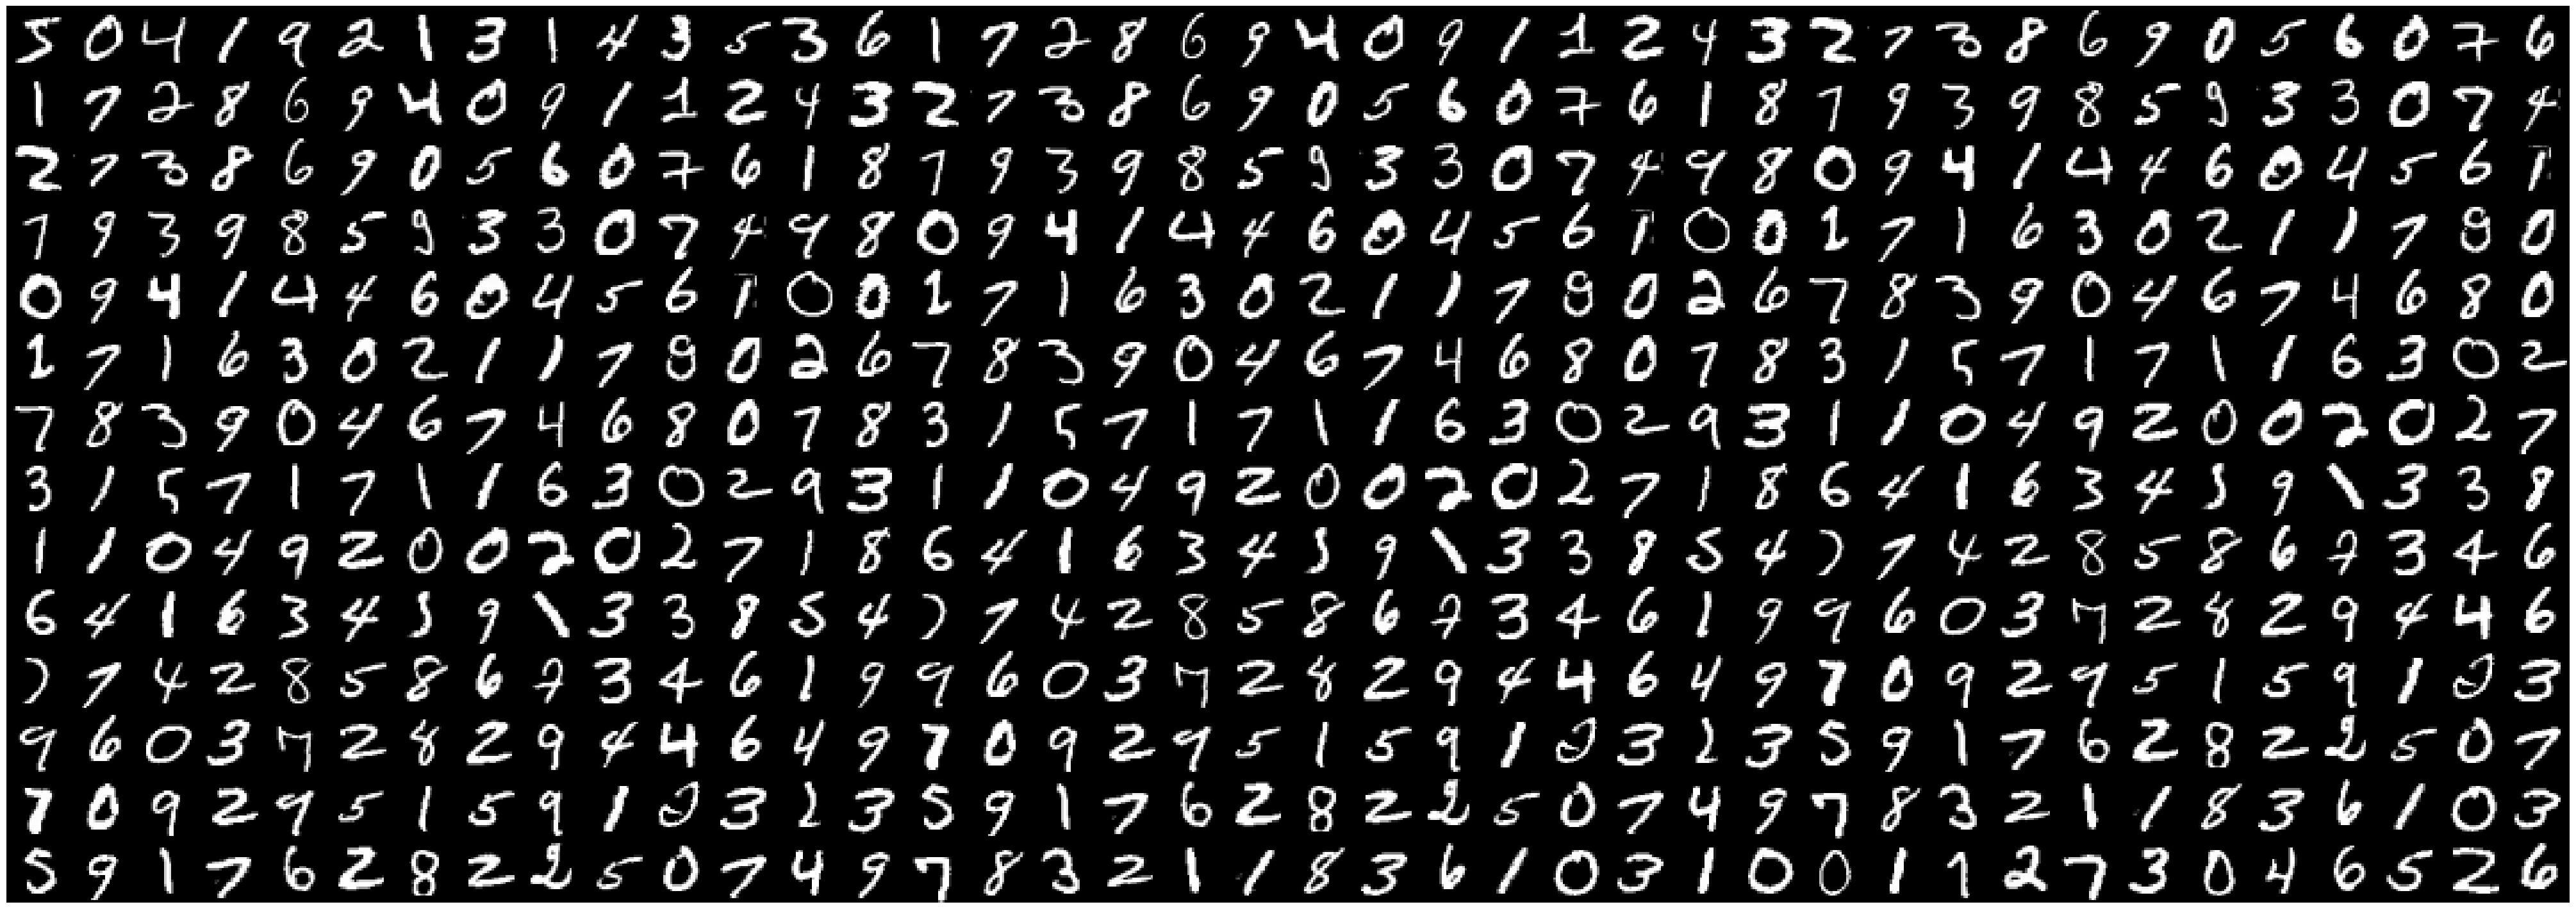

In [9]:
# Let's take a look at the dataset
import matplotlib.pyplot as plt
rows, cols = 14, 40 
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols, rows))
for i in range(rows):
    for j in range(cols):
        index = i * rows + j
        ax = axes[i, j]
        img_tensor, _ = train_data[index]
        img = img_tensor.numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
plt.show()

In [10]:
# Define the model
import torch
import torch.nn as nn

lat_v_size = 64
img_size = 28 * 28

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(img_size, lat_v_size)
        
    def forward(self, x):
        x = self.l1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(lat_v_size, img_size)
        
    def forward(self, x):
        x = self.l1(x)
        return x
        
encoder = Encoder()
decoder = Decoder()

In [11]:
# Define the optmizer
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
opt = torch.optim.Adam(params_to_optimize, lr=1e-3)

In [12]:
# Train the model
from tqdm import tqdm
batch_size = 64
loss_fn = torch.nn.MSELoss()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
losses = []
encoder.train()
decoder.train()
for batch, _ in tqdm(train_loader):
    batch = batch.reshape((-1, 1, 28*28))
    lat_v = encoder(batch)
    out = decoder(lat_v)
    loss = loss_fn(out, batch)
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.detach().numpy())
encoder.eval()
decoder.eval()

100%|██████████| 938/938 [00:11<00:00, 81.36it/s]


Decoder(
  (l1): Linear(in_features=64, out_features=784, bias=True)
)

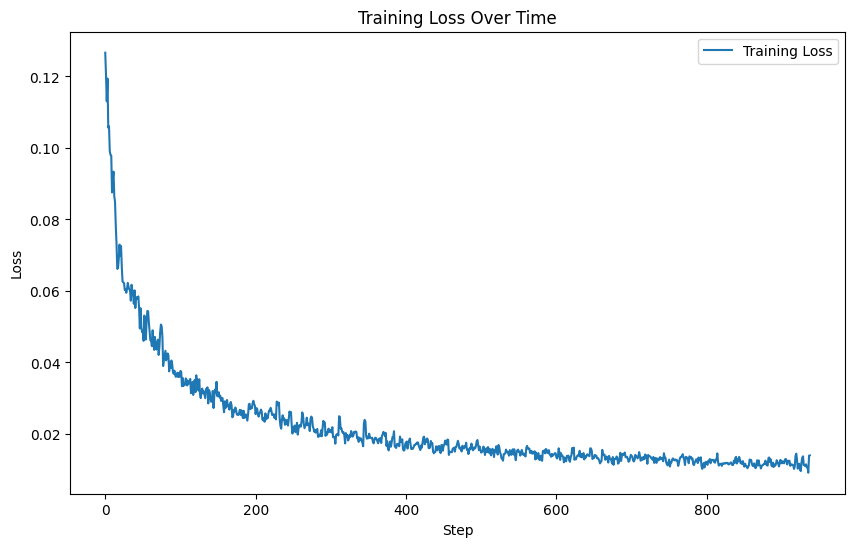

In [13]:
# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

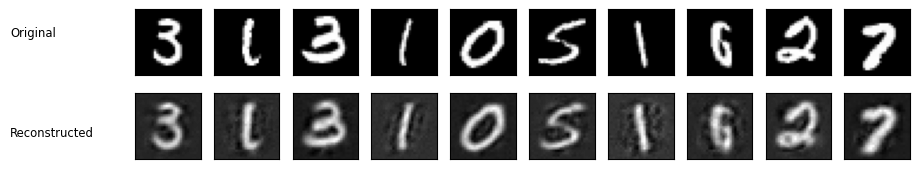

In [15]:
# Let's do some inference and see how do output look
rows, cols = 2, 10
sample_size = rows*cols
rand_ids = torch.randperm(len(test_data))[:sample_size]
rand_imgs = torch.stack([test_data[i][0] for i in rand_ids])

out = decoder(encoder(rand_imgs.reshape(-1, 1, 28*28)))

fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True, figsize=(cols, rows))

reconstructed_images = out.detach().numpy().reshape(-1, 28, 28) 

for i, ax in enumerate(axes[0]):
    ax.imshow(rand_imgs[i].squeeze(), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
for i, ax in enumerate(axes[1]):
    ax.imshow(reconstructed_images[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

fig.text(0.0, 0.75, 'Original', va='center', ha='left', rotation='horizontal', size='small')
fig.text(0.0, 0.25, 'Reconstructed', va='center', ha='left', rotation='horizontal', size='small')

plt.show()

In [16]:
# Let's calculate the average loss of the train data
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
total_loss = 0.0
num_batches = 0
for batch, _ in test_loader:
    batch = batch.reshape((-1, 1, 28*28))
    lat_v = encoder(batch)
    out = decoder(lat_v)
    total_loss += loss_fn(out, batch).item()
    num_batches += 1
average_loss = total_loss / num_batches
print(f'Average loss over the training dataset: {average_loss}')

Average loss over the training dataset: 0.011807023974528699
